In [16]:
# %%
# --- STEP 1: GLOBAL CONFIGURATION & IMPORTS ---
import pandas as pd
import numpy as np
import os
import sys
import glob

# 1. PATH CONFIGURATION
# Adjust 'DATA_DIR' if your notebook is not in 'notebooks/'
DATA_DIR = os.path.join("..", "data", "raw") 
SRC_DIR = os.path.join("..", "src"

SyntaxError: incomplete input (1328006717.py, line 12)

In [17]:
# 2. DOWNLOAD CHECK (Optional)
# If raw files are missing, we attempt to run your existing download scripts.
# Set DOWNLOAD_MISSING = False to skip this check entirely.
DOWNLOAD_MISSING = True

def check_and_download():
    required_files = [
        "acs_tract_demographics_2023.csv", # Tract Data
        "psam_p*.csv",                     # Person Data (Wildcard)
        "snap_county_data_clean.csv"       # SNAP Data
    ]
    
    missing = []
    for f in required_files:
        if '*' in f:
            if not glob.glob(os.path.join(DATA_DIR, f)):
                missing.append(f)
        else:
            if not os.path.exists(os.path.join(DATA_DIR, f)):
                missing.append(f)
    
    if missing and DOWNLOAD_MISSING:
        print(f"⚠️ Missing files: {missing}. Attempting download...")
        sys.path.append(os.path.abspath(SRC_DIR))
        try:
            import download_acs, download_tract_data, download_saipe
            # Trigger downloads (assuming these modules have main() or equivalent)
            if "acs_tract" in str(missing): download_tract_data.main()
            if "psam_p" in str(missing): download_acs.download_acs_data()
            if "saipe" in str(missing): download_saipe.main()
            print("✅ Downloads complete.")
        except ImportError:
            print("❌ Could not import download scripts from '../src'. Please check paths.")
    elif not missing:
        print("✅ All raw files present.")

check_and_download()

✅ All raw files present.


In [27]:
# %%
# --- STEP 2: ETL & SCHEMA ENFORCEMENT (FIXED) ---
# Changes:
# 1. Dropped 'State_Code' from Person Data (caused KeyError).
# 2. Kept 'PUMA' for Person Data.
# 3. Kept 'GEOID_COUNTY' for Tract Data.

import pandas as pd
import numpy as np
import os
import glob

# CONFIGURATION
DATA_DIR = os.path.join("..", "data", "raw") 

def load_strict_data_v3():
    print("🚀 Loading Data (Strict Mode + PUMA)...")
    
    # ====================================================
    # 1. TRACTS (The Prediction Canvas)
    # ====================================================
    t_path = os.path.join(DATA_DIR, "acs_tract_demographics_2023.csv")
    df_tract = pd.read_csv(t_path)
    
    # Fix IDs
    df_tract['state'] = df_tract['state'].astype(str).str.zfill(2)
    df_tract['county'] = df_tract['county'].astype(str).str.zfill(3)
    df_tract['tract'] = df_tract['tract'].astype(str).str.split('.').str[0].str.zfill(6)
    df_tract['GEOID'] = df_tract['state'] + df_tract['county'] + df_tract['tract']
    
    # NEW: Create Explicit County ID (State + County)
    df_tract['GEOID_COUNTY'] = df_tract['state'] + df_tract['county']
    
    # Select Columns
    # (Dynamically select bucket columns to be safe)
    age_sex_cols = [c for c in df_tract.columns if c.startswith('m_') or c.startswith('f_')]
    race_cols = [c for c in df_tract.columns if c.startswith('race_')]
    
    target_cols = ['GEOID', 'GEOID_COUNTY', 'total_population', 'poverty_count_est', 'poverty_count_moe'] + age_sex_cols + race_cols
    
    # Safe Select
    final_t_cols = [c for c in target_cols if c in df_tract.columns]
    df_tract_clean = df_tract[final_t_cols].copy()
    print(f"   ✅ Tracts: {df_tract_clean.shape} (With GEOID_COUNTY)")

    # ====================================================
    # 2. PEOPLE (The Training Data)
    # ====================================================
    p_files = glob.glob(os.path.join(DATA_DIR, "psam_p*.csv"))
    df_p = pd.read_csv(p_files[0], nrows=None) 
    
    # Clean & Create Target
    df_p = df_p.dropna(subset=['POVPIP']).copy()
    df_p['is_poor'] = (df_p['POVPIP'] < 100).astype(int)
    
    # Rename
    p_rename = {
        'PWGTP': 'Person_Weight',
        'AGEP': 'Age',
        'SEX': 'Sex_Code',
        'RAC1P': 'Race_Code',
        'PUMA': 'PUMA'
        # 'ST': 'State_Code'  <-- REMOVED per instruction
    }
    df_p = df_p.rename(columns=p_rename)
    
    # Schema (Dropped State_Code)
    p_cols = ['is_poor', 'Person_Weight', 'Age', 'Sex_Code', 'Race_Code', 'PUMA']
    
    # Safe Select
    present_p = [c for c in p_cols if c in df_p.columns]
    df_p_clean = df_p[present_p].copy()
    print(f"   ✅ People: {df_p_clean.shape} (With PUMA)")

    # ====================================================
    # 3. COUNTIES (SNAP + SAIPE)
    # ====================================================
    s_path = os.path.join(DATA_DIR, "snap_county_data_clean.csv")
    df_snap = pd.read_csv(s_path)
    if 'fips' in df_snap.columns: 
        df_snap['GEOID_COUNTY'] = df_snap['fips'].astype(str).str.zfill(5).str[:5]
    
    # Try SAIPE
    saipe_files = glob.glob(os.path.join(DATA_DIR, "*saipe*.csv"))
    if saipe_files:
        df_saipe = pd.read_csv(saipe_files[0])
        df_saipe['GEOID_COUNTY'] = df_saipe['state_fips'].astype(str).str.zfill(2) + \
                                   df_saipe['county_fips'].astype(str).str.zfill(3)
        df_county = pd.merge(df_snap, df_saipe, on='GEOID_COUNTY', how='inner')
        df_county = df_county.rename(columns={'saipe_poverty_count': 'saipe_poverty_est'})
    else:
        df_county = df_snap
        
    c_cols = ['GEOID_COUNTY', 'snap_persons_total', 'saipe_poverty_est', 'saipe_poverty_moe']
    df_county_clean = df_county[[c for c in c_cols if c in df_county.columns]].copy()
    print(f"   ✅ Counties: {df_county_clean.shape}")

    return df_tract_clean, df_p_clean, df_county_clean

# EXECUTE
df_tract, df_p, df_county = load_strict_data_v3()

# Inspect
print("\n🔍 New Person Data Sample:")
# Only display what we actually have
disp_cols = [c for c in ['is_poor', 'PUMA'] if c in df_p.columns]
display(df_p[disp_cols].head(3))

🚀 Loading Data (Strict Mode + PUMA)...
   ✅ Tracts: (3879, 58) (With GEOID_COUNTY)
   ✅ People: (6223, 6) (With PUMA)
   ✅ Counties: (148, 3)

🔍 New Person Data Sample:


,is_poor,PUMA
0,1,104
8,1,101
15,0,102


In [29]:
# %%
# --- STEP 3: DATA INSPECTION & DICTIONARY ---
# Goal: Verify the data structure and explain the columns.
# Layout: Targets (Y) are fixed on the left. Features (X) follow on the right.

def inspect_data_structure():
    print("🔍 INSPECTING REFACTORED DATASTRUCTURE...\n")
    
    # ====================================================
    # 1. TRACTS (The Canvas)
    # ====================================================
    print(f"--- A. TRACT DATA (Rows: {len(df_tract)}, Cols: {len(df_tract.columns)}) ---")
    print("   Role: The 'X' (Inputs) and 'Y' (Census Estimates) for the model application.")
    
    # REORDER: Targets Left, Demographics Right
    # Identify feature columns (Age/Sex/Race)
    demo_cols = [c for c in df_tract.columns if c.startswith('m_') or c.startswith('f_') or c.startswith('race_')]
    # Identify info/target columns
    core_cols = [c for c in df_tract.columns if c not in demo_cols]
    
    # Sort core columns to put GEOID and Poverty first
    priority_order = ['GEOID', 'poverty_count_est', 'poverty_count_moe', 'total_population']
    ordered_core = [c for c in priority_order if c in core_cols] + [c for c in core_cols if c not in priority_order]
    
    # Create View
    df_tract_view = df_tract[ordered_core + demo_cols]
    
    display(df_tract_view.head(3))
    print("   Column Key:")
    print("   * poverty_count_est: The official Census estimate (Target to smooth).")
    print("   * poverty_count_moe: The uncertainty (Noise floor).")
    print("   * m_XX / f_XX: Counts of Males/Females in specific age bins.")
    print("   * race_XX: Counts of racial groups.")
    print("-" * 60)

# ====================================================
    # 2. PEOPLE (The Training Data)
    # ====================================================
    print(f"\n--- B. PERSON DATA (Rows: {len(df_p)}, Cols: {len(df_p.columns)}) ---")
    print("   Role: The 'Training Set'. Learning the probability of poverty given demographics.")
    
    # REORDER: Add PUMA to the priority list
    p_priority = ['is_poor', 'Person_Weight', 'Age', 'Sex_Code', 'Race_Code', 'PUMA']
    
    # Safety check if cols exist
    p_view_cols = [c for c in p_priority if c in df_p.columns]
    
    display(df_p[p_view_cols].head(3))
    print("   Column Key:")
    print("   * is_poor: Binary Target (1 = Below Poverty Line, 0 = Above).")
    print("   * Person_Weight: Expansion weight (This 1 row represents X people).")
    print("   * PUMA: Public Use Microdata Area (Rough spatial location).") 
    print("   * Sex_Code: 1=Male, 2=Female.")
    print("   * Race_Code: 1=White, 2=Black, 6=Asian, etc.")
    print("-" * 60)

    # ====================================================
    # 3. COUNTIES (The Anchors)
    # ====================================================
    print(f"\n--- C. COUNTY DATA (Rows: {len(df_county)}, Cols: {len(df_county.columns)}) ---")
    print("   Role: The 'Ground Truth' anchors for validation.")
    
    # REORDER: SNAP/SAIPE first
    c_priority = ['GEOID_COUNTY', 'snap_persons_total', 'saipe_poverty_est', 'saipe_poverty_moe']
    c_view_cols = [c for c in c_priority if c in df_county.columns]
    
    display(df_county[c_view_cols].head(3))
    print("   Column Key:")
    print("   * snap_persons_total: Actual administrative count of recipients.")
    print("   * saipe_poverty_est: Official model-based poverty estimate.")

inspect_data_structure()

🔍 INSPECTING REFACTORED DATASTRUCTURE...

--- A. TRACT DATA (Rows: 3879, Cols: 58) ---
   Role: The 'X' (Inputs) and 'Y' (Census Estimates) for the model application.


,GEOID,poverty_count_est,poverty_count_moe,total_population,GEOID_COUNTY,m_00_04,m_05_09,m_10_14,m_15_17,m_18_19,...,f_75_79,f_80_84,f_85_plus,race_white,race_black,race_native,race_asian,race_pacific,race_other,race_two_more
0,24001000100,297,162,3153,24001,88,130,13,39,47,...,87,13,19,3098,21,0,0,0,0,34
1,24001000200,364,246,4094,24001,82,64,83,84,20,...,20,112,30,3203,753,6,15,0,0,117
2,24001000500,528,199,2269,24001,0,104,70,35,82,...,41,15,56,1706,334,0,8,0,37,184


   Column Key:
   * poverty_count_est: The official Census estimate (Target to smooth).
   * poverty_count_moe: The uncertainty (Noise floor).
   * m_XX / f_XX: Counts of Males/Females in specific age bins.
   * race_XX: Counts of racial groups.
------------------------------------------------------------

--- B. PERSON DATA (Rows: 6223, Cols: 6) ---
   Role: The 'Training Set'. Learning the probability of poverty given demographics.


,is_poor,Person_Weight,Age,Sex_Code,Race_Code,PUMA
0,1,30,75,1,2,104
8,1,11,55,1,2,101
15,0,23,50,1,1,102


   Column Key:
   * is_poor: Binary Target (1 = Below Poverty Line, 0 = Above).
   * Person_Weight: Expansion weight (This 1 row represents X people).
   * PUMA: Public Use Microdata Area (Rough spatial location).
   * Sex_Code: 1=Male, 2=Female.
   * Race_Code: 1=White, 2=Black, 6=Asian, etc.
------------------------------------------------------------

--- C. COUNTY DATA (Rows: 148, Cols: 3) ---
   Role: The 'Ground Truth' anchors for validation.


,GEOID_COUNTY,snap_persons_total,saipe_poverty_est
0,11001,58175.0,98811
1,24001,7637.0,11503
2,24003,10044.0,36637


   Column Key:
   * snap_persons_total: Actual administrative count of recipients.
   * saipe_poverty_est: Official model-based poverty estimate.


📊 Analyzing Person-Level Dynamics (Weighted)...


/var/folders/0s/d2ycgfq576zdm73qwlf4r6gc0000gn/T/ipykernel_52726/3239643232.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pop_counts.index, y=pop_counts.values, ax=axes[0], palette='viridis')
/var/folders/0s/d2ycgfq576zdm73qwlf4r6gc0000gn/T/ipykernel_52726/3239643232.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grp_race.index, y=grp_race.values, ax=axes[1], palette='magma')
/var/folders/0s/d2ycgfq576zdm73qwlf4r6gc0000gn/T/ipykernel_52726/3239643232.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silen

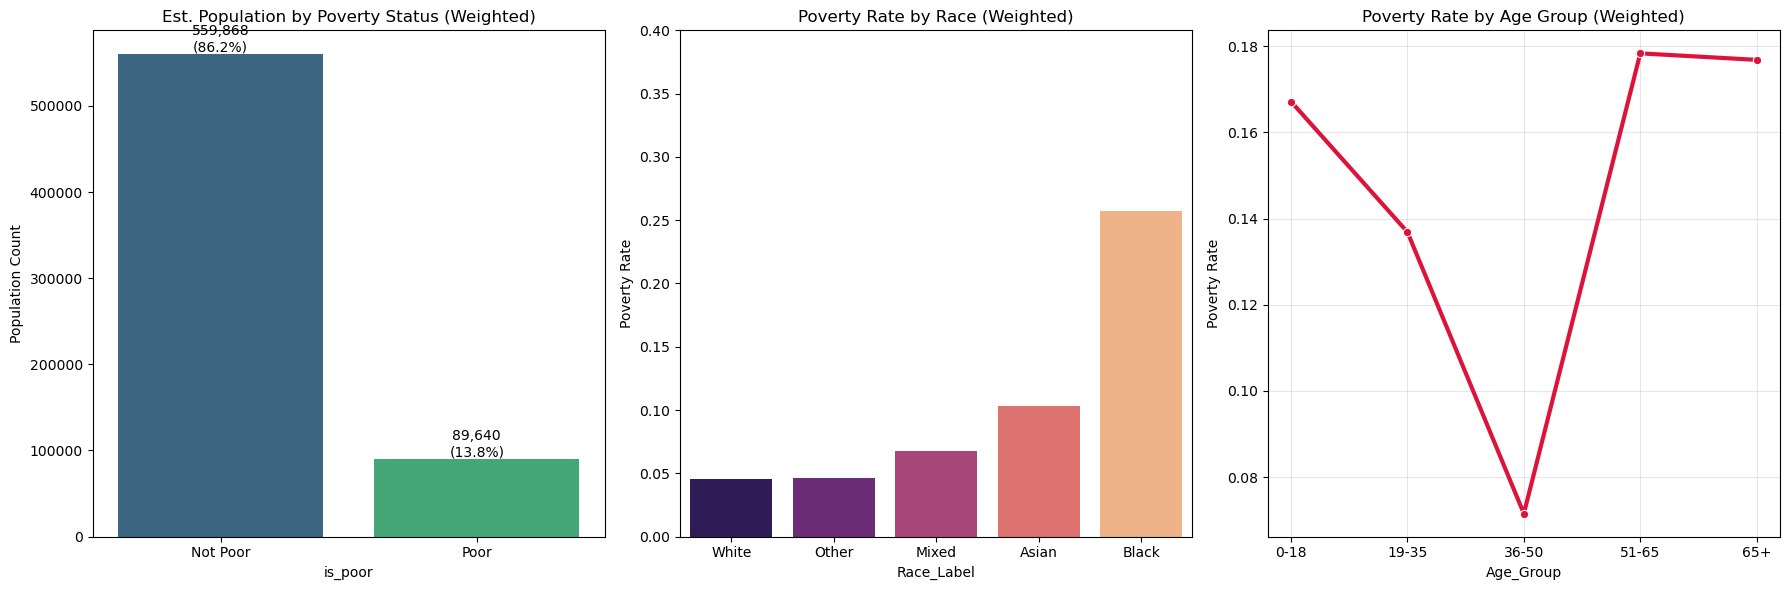

In [19]:
# %%
# --- STEP 4: TARGET ANALYSIS (PERSON LEVEL) ---
# Goal: Understand the relationship between Age, Race, and Poverty using WEIGHTED data.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_person_behavior():
    print("📊 Analyzing Person-Level Dynamics (Weighted)...")
    
    # 1. PREPARE DATA
    # We work on a copy to avoid setting warnings
    df_viz = df_p.copy()
    
    # Map Race Codes for Plotting (Census -> Label)
    race_map = {1: 'White', 2: 'Black', 6: 'Asian', 8: 'Other', 9: 'Mixed'}
    # Note: If codes 3,4,5,7 exist in data but not map, they go to 'Other'
    df_viz['Race_Label'] = df_viz['Race_Code'].map(race_map).fillna('Other')
    
    # Create Age Groups
    df_viz['Age_Group'] = pd.cut(df_viz['Age'], 
                                 bins=[0, 18, 35, 50, 65, 100], 
                                 labels=['0-18', '19-35', '36-50', '51-65', '65+'])

    # 2. PLOT: CLASS BALANCE (WEIGHTED)
    # We sum the weights to see the ACTUAL estimated population distribution
    pop_counts = df_viz.groupby('is_poor')['Person_Weight'].sum()
    pop_share = pop_counts / pop_counts.sum()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # A. Class Balance
    sns.barplot(x=pop_counts.index, y=pop_counts.values, ax=axes[0], palette='viridis')
    axes[0].set_title("Est. Population by Poverty Status (Weighted)")
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Not Poor', 'Poor'])
    axes[0].set_ylabel("Population Count")
    # Add labels
    for i, v in enumerate(pop_counts.values):
        axes[0].text(i, v, f"{v:,.0f}\n({pop_share.iloc[i]:.1%})", ha='center', va='bottom')

    # B. Poverty Rate by Race (Weighted)
    # Rate = Sum(Weights of Poor in Group) / Sum(Total Weights in Group)
    grp_race = df_viz.groupby('Race_Label').apply(
        lambda x: x.loc[x['is_poor']==1, 'Person_Weight'].sum() / x['Person_Weight'].sum()
    ).sort_values()
    
    sns.barplot(x=grp_race.index, y=grp_race.values, ax=axes[1], palette='magma')
    axes[1].set_title("Poverty Rate by Race (Weighted)")
    axes[1].set_ylabel("Poverty Rate")
    axes[1].set_ylim(0, 0.4)

    # C. Poverty Rate by Age (Weighted)
    grp_age = df_viz.groupby('Age_Group').apply(
        lambda x: x.loc[x['is_poor']==1, 'Person_Weight'].sum() / x['Person_Weight'].sum()
    )
    
    sns.lineplot(x=grp_age.index, y=grp_age.values, ax=axes[2], marker='o', color='crimson', lw=3)
    axes[2].set_title("Poverty Rate by Age Group (Weighted)")
    axes[2].set_ylabel("Poverty Rate")
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_person_behavior()

⚖️ Validating County Anchors...


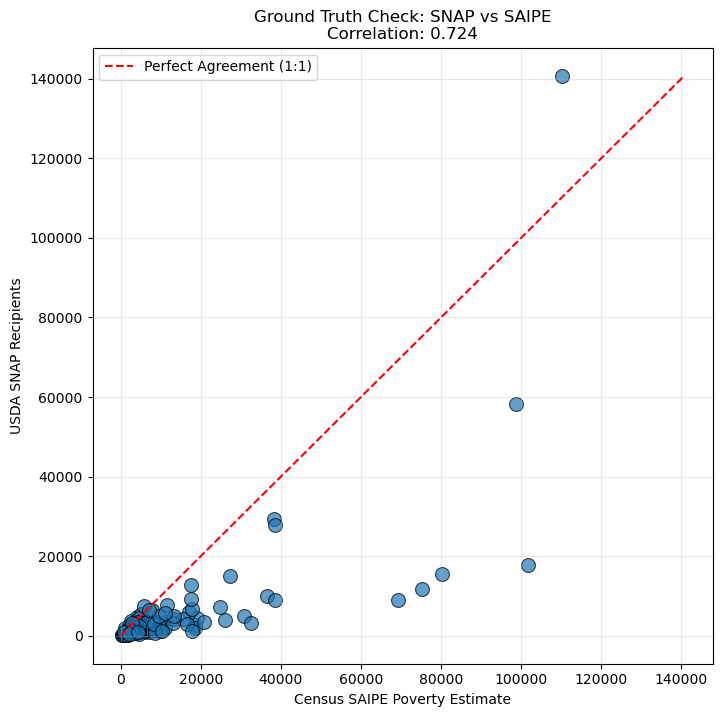

In [20]:
# %%
# --- STEP 5: ANCHOR VALIDATION (COUNTY LEVEL) ---
# Goal: Compare USDA SNAP (Reality) vs Census SAIPE (Modeled Estimate).
from scipy.stats import pearsonr

def analyze_county_anchors():
    print("⚖️ Validating County Anchors...")
    
    # We use df_county which has both SNAP and SAIPE
    if 'saipe_poverty_est' not in df_county.columns:
        print("⚠️ SAIPE data missing. Skipping comparison.")
        return

    # Correlation
    x = df_county['saipe_poverty_est']
    y = df_county['snap_persons_total']
    corr, _ = pearsonr(x, y)
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=df_county, x='saipe_poverty_est', y='snap_persons_total', 
                    s=100, alpha=0.7, edgecolor='k')
    
    # Reference Line (x=y)
    max_val = max(x.max(), y.max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Agreement (1:1)')
    
    plt.title(f"Ground Truth Check: SNAP vs SAIPE\nCorrelation: {corr:.3f}")
    plt.xlabel("Census SAIPE Poverty Estimate")
    plt.ylabel("USDA SNAP Recipients")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

analyze_county_anchors()

🗺️ Generating Maps (3-Way Comparison)...


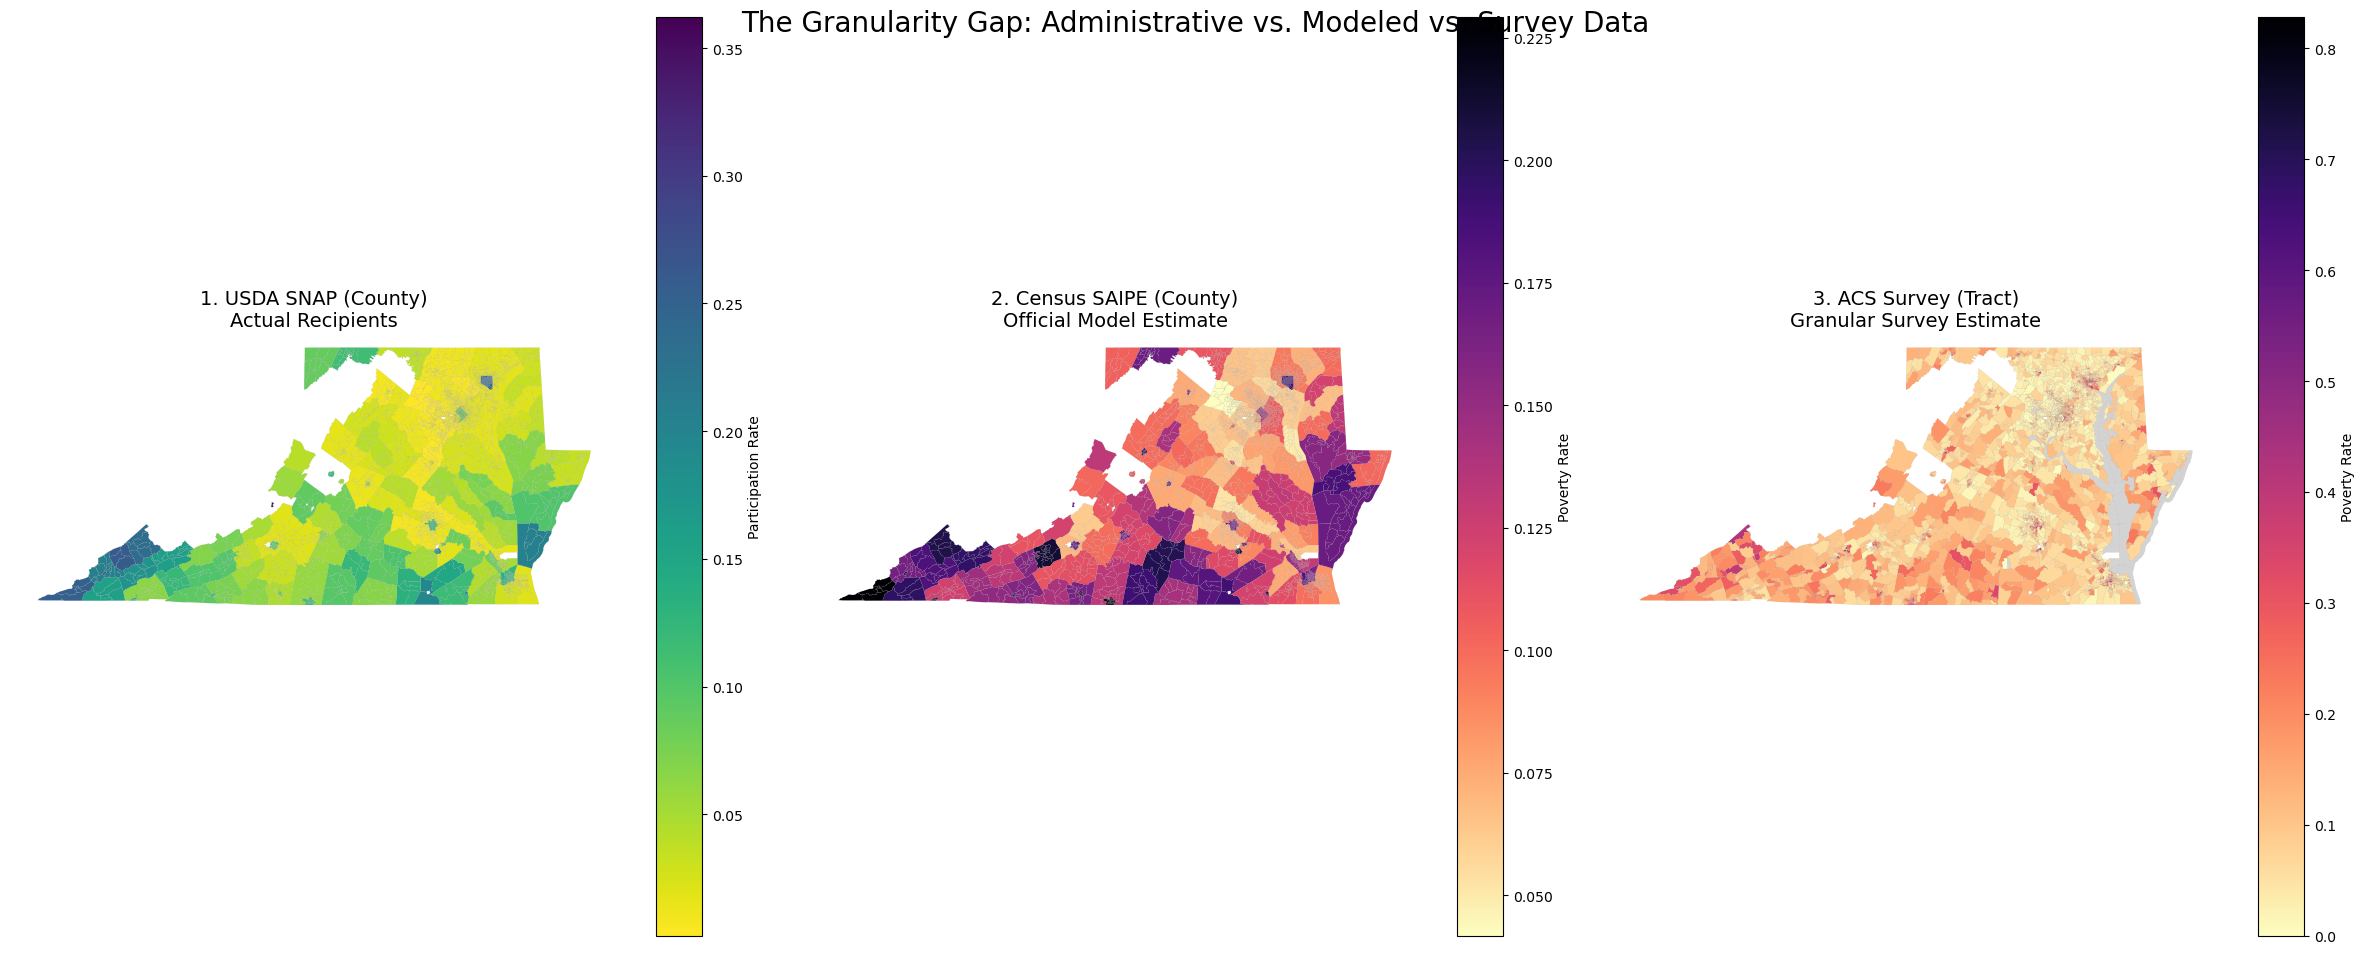

In [23]:
# %%
# --- STEP 6: GIS VISUALIZATION (THE MAP) ---
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_refactored_map():
    print("🗺️ Generating Maps (3-Way Comparison)...")
    
    # 1. LOAD SHAPEFILES
    # We download all 3 states (DC, MD, VA)
    urls = [
        "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_11_tract.zip",
        "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_24_tract.zip",
        "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_51_tract.zip"
    ]
    
    gdf_list = []
    for url in urls:
        try:
            # Check for local file first to save bandwidth
            filename = os.path.basename(url)
            if os.path.exists(filename):
                gdf_list.append(gpd.read_file(filename))
            else:
                gdf_list.append(gpd.read_file(url))
        except:
            pass # Skip if download fails (safe mode)
            
    if not gdf_list:
        print("❌ Shapefile download failed.")
        return

    gdf = pd.concat(gdf_list, ignore_index=True)
    
    # 2. FILTER & JOIN
    # The 'clean' df_tract already has the perfect GEOID key.
    # The shapefile has 'GEOID' (11 digits).
    
    # Filter to our counties (from df_county)
    target_counties = df_county['GEOID_COUNTY'].unique()
    gdf['county_geoid'] = gdf['GEOID'].str[:5]
    gdf_dmv = gdf[gdf['county_geoid'].isin(target_counties)].copy()
    
    # Merge Tract Data
    # Note: df_tract has 'poverty_count_est' and 'total_population'
    df_tract['acs_rate'] = df_tract['poverty_count_est'] / df_tract['total_population']
    
    # Left Join: Shapefile -> Data
    gdf_dmv = gdf_dmv.merge(df_tract[['GEOID', 'acs_rate']], on='GEOID', how='left')
    
    # Merge County Data (Broadcast SNAP & SAIPE Rates)
    # Calculate Denominator (Total Pop of County)
    county_pop = df_tract.groupby(df_tract['GEOID'].str[:5])['total_population'].sum().reset_index()
    county_pop.columns = ['GEOID_COUNTY', 'county_total_pop']
    
    # Merge Pop into County Data to calculate rates
    df_county_map = df_county.merge(county_pop, on='GEOID_COUNTY', how='left')
    
    # Rate 1: SNAP (Participation)
    df_county_map['snap_rate'] = df_county_map['snap_persons_total'] / df_county_map['county_total_pop']
    
    # Rate 2: SAIPE (Modeled Poverty)
    if 'saipe_poverty_est' in df_county_map.columns:
        df_county_map['saipe_rate'] = df_county_map['saipe_poverty_est'] / df_county_map['county_total_pop']
    else:
        df_county_map['saipe_rate'] = 0 # Fallback if missing
    
    # Broadcast to Shapefile
    gdf_dmv = gdf_dmv.merge(df_county_map[['GEOID_COUNTY', 'snap_rate', 'saipe_rate']], 
                            left_on='county_geoid', right_on='GEOID_COUNTY', how='left')
    
    # 3. PLOT (3 PANELS)
    fig, ax = plt.subplots(1, 3, figsize=(24, 10))
    
    # Common Style
    style_kwds = {'linewidth': 0.05, 'edgecolor': 'grey', 'legend': True, 'missing_kwds': {'color': 'lightgrey'}}
    
    # Map 1: SNAP (The Reality)
    gdf_dmv.plot(column='snap_rate', cmap='viridis_r', ax=ax[0], 
                 legend_kwds={'label': "Participation Rate"}, **style_kwds)
    ax[0].set_title("1. USDA SNAP (County)\nActual Recipients", fontsize=14)
    ax[0].set_axis_off()

    # Map 2: SAIPE (The Anchor)
    gdf_dmv.plot(column='saipe_rate', cmap='magma_r', ax=ax[1],
                 legend_kwds={'label': "Poverty Rate"}, **style_kwds)
    ax[1].set_title("2. Census SAIPE (County)\nOfficial Model Estimate", fontsize=14)
    ax[1].set_axis_off()

    # Map 3: ACS (The Granularity)
    gdf_dmv.plot(column='acs_rate', cmap='magma_r', ax=ax[2],
                 legend_kwds={'label': "Poverty Rate"}, **style_kwds)
    ax[2].set_title("3. ACS Survey (Tract)\nGranular Survey Estimate", fontsize=14)
    ax[2].set_axis_off()
    
    plt.suptitle("The Granularity Gap: Administrative vs. Modeled vs. Survey Data", fontsize=20, y=0.95)
    plt.tight_layout()
    plt.show()

plot_refactored_map()